In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/MyDrive/image_classification/processed_files.json /content/
# !cp /content/drive/MyDrive/image_classification/image_recg.rar /content/
# !cp /content/drive/MyDrive/image_classification/requirements.txt /content/

# !ls
# drive.flush_and_unmount()


Mounted at /content/drive
drive  image_recg.rar  processed_files.json  requirements.txt  sample_data


In [2]:
# !unrar x image_recg.rar

Streaming output truncated to the last 5000 lines.
Extracting  dataset/Faces_easy/image_0242.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0243.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0244.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0245.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0246.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0247.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0248.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0249.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0250.jpg                             55%  OK 
Extracting  dataset/Faces_easy/image_0251.jpg                             55%  OK 
Extracting  dataset/Faces_eas

In [3]:
# !pip install -r requirements.txt

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm.auto import tqdm
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

In [2]:
with open("processed_files.json") as file:
    p = json.load(file)


In [3]:
p.keys()

dict_keys(['accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball'

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dict, transform=None, resize_dim=(128,128)):
        self.data_dict = data_dict
        self.class_names = list(data_dict.keys())
        self.transform = transform
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.samples = self.process_data(resize_dim)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = sample['img']
        bounding_box = sample['coords']
        label = sample['label']

        image = Image.open(f"dataset/{self.class_names[label]}/{image}").convert("RGB")

        image = self.transform(image)

        return image, bounding_box, label

    def process_data(self,resize_dim):
        samples = []

        for class_name, class_idx in self.class_indices.items():
            for sample in self.data_dict[class_name]:
                image = Image.open(f"dataset/{class_name}/{sample['img_name']}").convert("RGB")

                new_bbox = transform_bbox(sample["coords"],image.size, resize_dim)
                # new_bbox = sample["coords"]
                del image
                sample_info = {
                    'img': sample['img_name'],
                    'coords': new_bbox,
                    'label': class_idx
                }
                samples.append(sample_info)

        return samples

In [5]:
from torchvision.models.resnet import ResNet50_Weights


class ClassifierWithBoundingBox(nn.Module):
    def __init__(self, num_classes):
        super(ClassifierWithBoundingBox, self).__init__()
        # Use a pre-trained ResNet model for classification
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

        # Add bounding box regression head
        self.bbox_head = nn.Sequential(
            nn.Linear(num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 4) # 4 for [x,y,x1,y1]
        )

    def forward(self, x):
        features = self.resnet(x)
        bbox = self.bbox_head(features)
        return features, bbox


In [6]:
size_dim = (256,256)
# Set up transforms
transform = transforms.Compose([
    transforms.Resize(size_dim),
    transforms.ToTensor(),
])

In [7]:
def transform_bbox(bounding_box, original_image_size, new_image_size):
    """
    Transform bounding box coordinates to match the given new image size.

    Args:
        bounding_box (list or tuple): Bounding box coordinates in the format (x1, y1, x2, y2).
        original_image_size (tuple): Original image size in the format (original_width, original_height).
        new_image_size (tuple): New image size in the format (new_width, new_height).

    Returns:
        list: Transformed bounding box coordinates in the format (x1, y1, x2, y2).
    """
    original_width, original_height = original_image_size
    new_width, new_height = new_image_size

    scale_x = new_width / original_width
    scale_y = new_height / original_height

    # Scale bounding box coordinates
    y1, y2, x1, x2 = bounding_box
    transformed_x1 = int(x1 * scale_x)
    transformed_y1 = int(y1 * scale_y)
    transformed_x2 = int(x2 * scale_x)
    transformed_y2 = int(y2 * scale_y)

    return [transformed_y1, transformed_y2, transformed_x1, transformed_x2]

In [8]:

def split_dataset(data_dict, test_size=0.2, random_state=42):
    all_samples = []

    for class_name, samples in data_dict.items():
        for sample in samples:
            sample_info = {
                'img_name': sample['img_name'],
                'coords': sample['coords'],
                'label': class_name
            }
            all_samples.append(sample_info)

    # Extract features (X) and labels (y) from the list of dictionaries
    X = [{'img_name': sample['img_name'], 'coords': sample['coords']} for sample in all_samples]
    y = [sample['label'] for sample in all_samples]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Organize the split data into dictionaries
    train_data = {class_name: [] for class_name in data_dict.keys()}
    test_data = {class_name: [] for class_name in data_dict.keys()}

    for sample, label in zip(X_train, y_train):
        train_data[label].append(sample)

    for sample, label in zip(X_test, y_test):
        test_data[label].append(sample)

    return train_data, test_data

In [9]:
train_data, test_data = split_dataset(p)

In [10]:
train_dataset = CustomDataset(train_data, transform,size_dim)
test_dataset = CustomDataset(test_data, transform,size_dim)

In [14]:

# im = Image.open(f"dataset/{train_dataset.class_names[train_dataset.samples[100]['label']]}/{train_dataset.samples[100]['img']}")


In [15]:
# img, bound, label = train_dataset[100]

In [16]:

# fig, ax = plt.subplots(1)

# image_np = np.transpose(img.numpy(), (1, 2, 0))
# # image_np = img.T


# ax.imshow(image_np)
# y1,y2,x1,x2 = np.array(bound).T
# w = x2-x1
# h = y2-y1
# rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# plt.title(f'Class: {train_dataset.class_names[label]}')
# plt.show()
# print(bound)

In [17]:
batch_size = 128

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [19]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# fetch one batch of data
image, bounding_box, label = next(iter(train_dataloader))
bounding_box = torch.stack(bounding_box)

bounding_box = bounding_box.T

image = image[0]
bound = bounding_box[0]
label = label[0]

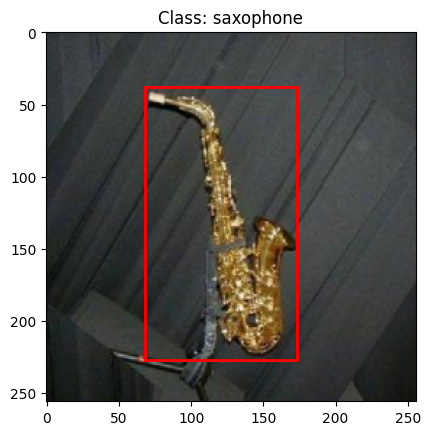

tensor([ 38, 227,  68, 173])


In [21]:

fig, ax = plt.subplots(1)

image_np = np.transpose(image.numpy(), (1, 2, 0))
# image_np = img.T


ax.imshow(image_np)
y1, y2, x1, x2 = np.array(bound).T
w = x2-x1
h = y2-y1
rect = patches.Rectangle((x1, y1), w, h, linewidth=2,
                         edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title(f'Class: {train_dataset.class_names[label]}')
plt.show()
print(bound)

In [22]:
def train_epoch(model,train_dataloader, classification_loss, regression_loss, optim, device):
    model.train()
    total_loss = 0

    for images, bounding_boxes, labels in tqdm(train_dataloader, desc="Training"):
        # images, bounding_boxes, labels = torch.tensor(images).to(device), torch.tensor(bounding_boxes).to(device), torch.tensor(labels).to(device)
        optim.zero_grad()
        # bounding_boxes = torch.tensor(bounding_boxes)
        # bounding_boxes = torch.Tensor(bounding_boxes)


        bounding_boxes = torch.stack(bounding_boxes).to(device)
        images = images.to(device)
        labels = labels.to(device)

        bounding_boxes = bounding_boxes.T



        features, predicted_bboxes = model(images)



        c_loss = classification_loss(features, labels)

        r_loss = regression_loss(predicted_bboxes, bounding_boxes)

        loss = c_loss + r_loss

        # total_loss += loss.item()
        loss.backward()
        optim.step()

        len_dloader = len(train_dataloader)

    return c_loss / len_dloader, r_loss / len_dloader

In [23]:
def test_epoch(model, test_dataloader, classification_loss, regression_loss, device):
    model.eval()
    total_loss = 0

    with torch.inference_mode():
        for images, bounding_boxes, labels in tqdm(test_dataloader, desc="Testing"):

            bounding_boxes = torch.stack(bounding_boxes).to(device)
            images = images.to(device)
            labels = labels.to(device)
            bounding_boxes = bounding_boxes.T


            features, predicted_bboxes = model(images)
            c_loss = classification_loss(features, labels)
            r_loss = regression_loss(predicted_bboxes, bounding_boxes)

        len_dloader = len(train_dataloader)

    return c_loss / len_dloader, r_loss / len_dloader

In [24]:
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ClassifierWithBoundingBox(num_classes=len(train_dataset.class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_classifier = nn.CrossEntropyLoss()
loss_regressor = nn.SmoothL1Loss()

for epoch in range(epochs):
    print("starting epoch", epoch+1)
    train_loss_classifier, train_loss_regressor = train_epoch(model, train_dataloader, loss_classifier, loss_regressor, optimizer, device=device)
    test_loss_classifier, test_loss_regressor = test_epoch(model, test_dataloader, loss_classifier, loss_regressor, device=device)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss classifier: {train_loss_classifier:.4f}, Test Loss classifier: {test_loss_classifier:.4f}")
    print(f"Epoch {epoch + 1}/{epochs} - Train Loss Regressor: {train_loss_regressor:.4f}, Test Loss Regressor: {test_loss_regressor:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 45.2MB/s]


starting epoch 1


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss classifier: 0.2020, Test Loss classifier: 0.1832
Epoch 1/15 - Train Loss Regressor: 0.3514, Test Loss Regressor: 0.3877
starting epoch 2


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss classifier: 0.0841, Test Loss classifier: 0.0967
Epoch 2/15 - Train Loss Regressor: 0.3586, Test Loss Regressor: 0.3581
starting epoch 3


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss classifier: 0.0207, Test Loss classifier: 0.0556
Epoch 3/15 - Train Loss Regressor: 0.2681, Test Loss Regressor: 0.2698
starting epoch 4


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss classifier: 0.0143, Test Loss classifier: 0.0457
Epoch 4/15 - Train Loss Regressor: 0.1756, Test Loss Regressor: 0.2442
starting epoch 5


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss classifier: 0.0210, Test Loss classifier: 0.0313
Epoch 5/15 - Train Loss Regressor: 0.1407, Test Loss Regressor: 0.2394
starting epoch 6


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss classifier: 0.0291, Test Loss classifier: 0.0320
Epoch 6/15 - Train Loss Regressor: 0.1469, Test Loss Regressor: 0.2233
starting epoch 7


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss classifier: 0.0171, Test Loss classifier: 0.0346
Epoch 7/15 - Train Loss Regressor: 0.1952, Test Loss Regressor: 0.2180
starting epoch 8


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss classifier: 0.0162, Test Loss classifier: 0.0291
Epoch 8/15 - Train Loss Regressor: 0.1456, Test Loss Regressor: 0.2099
starting epoch 9


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss classifier: 0.0115, Test Loss classifier: 0.0453
Epoch 9/15 - Train Loss Regressor: 0.1361, Test Loss Regressor: 0.1974
starting epoch 10


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss classifier: 0.0105, Test Loss classifier: 0.0350
Epoch 10/15 - Train Loss Regressor: 0.0980, Test Loss Regressor: 0.1837
starting epoch 11


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss classifier: 0.0067, Test Loss classifier: 0.0291
Epoch 11/15 - Train Loss Regressor: 0.1130, Test Loss Regressor: 0.2263
starting epoch 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
# for epoch in range(epochs):
#     print("starting epoch", epoch+1)
#     train_loss = train_epoch(model, train_dataloader, loss_classifier, loss_regressor, optimizer, device=device)
#     test_loss = test_epoch(model, test_dataloader, loss_classifier, loss_regressor, device=device)

#     print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

In [44]:
import random
image, bounding_box, label = random.sample(list(test_dataset),1)[0]
bounding_box = torch.tensor(bounding_box)

bound = bounding_box.T

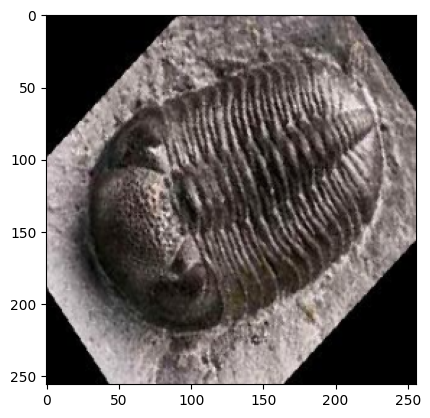

In [45]:
plt.imshow(image.T)

In [46]:
def make_pred(image):
    model.eval()

    with torch.inference_mode():
        features, predicted_bboxes = model(torch.stack([image]).to(device))
        pred_prob = torch.softmax(features.squeeze(),dim=0)
        pred_class = pred_prob.argmax().cpu()
        pred_box = predicted_bboxes.cpu()

    return pred_box, pred_class

In [47]:
pred_box,pred_class = make_pred(image)

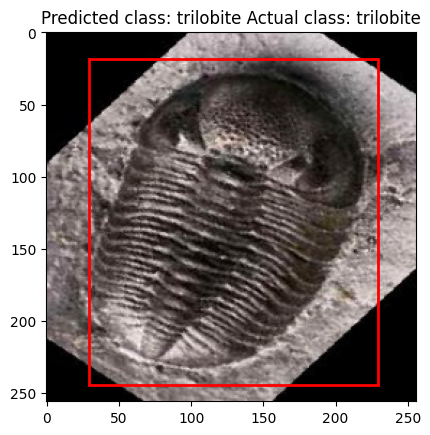

In [48]:
def plot_image(image, pred_box, pred_class):
    fig, ax = plt.subplots(1)

    image_np = np.transpose(image.numpy(), (1, 2, 0))
    # image_np = img.T


    ax.imshow(image_np)
    y1, y2, x1, x2 = np.array(pred_box).T
    w = x2-x1
    h = y2-y1
    rect = patches.Rectangle((x1, y1), w, h, linewidth=2,
                            edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(f'Predicted class: {train_dataset.class_names[pred_class]} Actual class: {train_dataset.class_names[label]}')
    plt.show()

plot_image(image,pred_box,pred_class)

In [49]:
import requests
from io import BytesIO
url = "https://t3.ftcdn.net/jpg/02/43/12/34/360_F_243123463_zTooub557xEWABDLk0jJklDyLSGl2jrr.jpg"
r = requests.get(url)


In [50]:
netimg = Image.open(BytesIO(r.content))

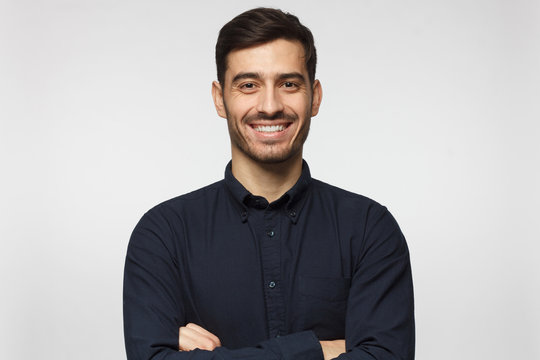

In [51]:
netimg

In [52]:
netimg = transform(netimg)

In [53]:
pred_box,pred_class = make_pred(netimg)

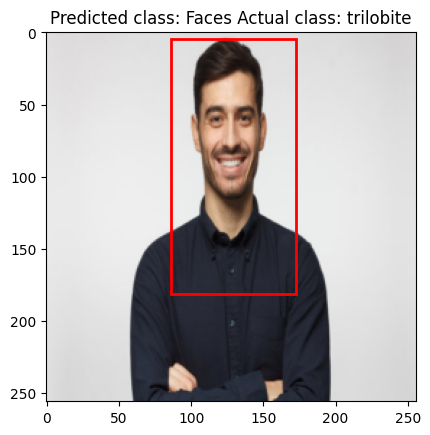

In [54]:
plot_image(netimg, pred_box, pred_class)

In [38]:
# torch.save(model.state_dict(), "image_classification_with_bounding_boxes.pt")

In [55]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp ./image_classification_with_bounding_boxes.pt /content/drive/MyDrive/image_classification
# drive.flush_and_unmount()


Mounted at /content/drive
